 CIFAR Code Along with CNN
The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load the CIFAR-10 datasets
## Load the CIFAR-10 dataset
PyTorch makes the CIFAR-10 train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.<br>The set contains 50,000 train and 10,000 test images.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [3]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data', train=False, download=True, transform=transform)

100.0%

Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

# Create Loader

In [6]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Define strings for labels

In [9]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
# don't use the variable name "class", as it would overwrite python's built-in keyword

# View a batch of images

Label: [     7      5      3      7      3      9      4      2      2      8]
Class:  horse   dog   cat horse   cat truck  deer  bird  bird  ship


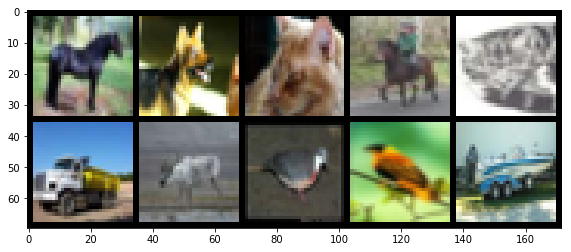

In [13]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:6}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Define the model 

In the previous section, the model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC. We'll use the same format here.

The only changes are:
* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input<br>

First convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt>

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

### Why <tt>(6x6x16)</tt> instead of <tt>(5x5x16)</tt> ?<br>
With MNIST the kernels and pooling layers resulted in $\;(((28−2)/2)−2)/2=5.5 \;$ which rounds down to 5 pixels per side.<br>
With CIFAR the result is $\;(((32-2)/2)-2)/2 = 6.5\;$ which rounds down to 6 pixels per side.</div>

In [16]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [18]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


# Define loss function & optimizer 


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model

In [20]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.67172015  accuracy:  27.080%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.91580963  accuracy:  33.130%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.89692688  accuracy:  36.797%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.40766621  accuracy:  39.123%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.40583444  accuracy:  41.118%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.28380609  accuracy:  51.260%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.35742259  accuracy:  51.795%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.20425415  accuracy:  52.280%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.14655077  accuracy:  52.653%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 2.19020438  accuracy:  53.048%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.26571691  accuracy:  56.840%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.47672486  accuracy:  57.150%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.95467967  accuracy:  57.257%
epoch:  2  b

# Save the model 

In [22]:
torch.save(model.state_dict(), 'C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/CNN/CIFAR10-CNN-Model.pt')

# Plot the loss and acc comparisons


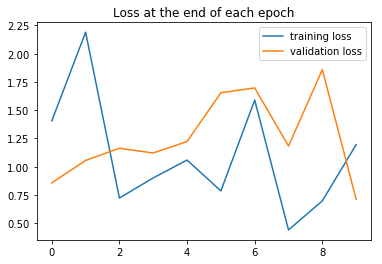

In [23]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

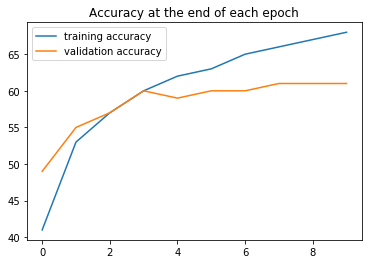

In [24]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Evaluate test data

In [25]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4920), tensor(5531), tensor(5765), tensor(6000), tensor(5994), tensor(6067), tensor(6016), tensor(6139), tensor(6135), tensor(6123)]

Test accuracy: 61.230%


# Display the confusion matrix 


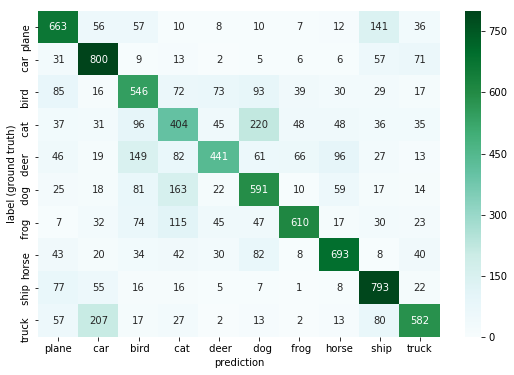

In [26]:
# Create a loader for the entire the test set, run through the model 
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [27]:
# Examine the misses 
# track the index positions of "missed" predictiions >> extract the corresponding image and label 
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

3877

In [28]:
# Display the first 8 index positions
misses[:8]

array([     3,      6,      7,      8,     12,     14,     17,     19],
      dtype=int64)

In [29]:
# Set up an iterator to feed batched rows
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [    3     6     7     8    12    14    17    19]
Label: [    0     1     6     3     5     9     7     6]
Class:  plane   car  frog   cat   dog truck horse  frog

Guess: [    8     5     4     5     1     1     3     5]
Class:   ship   dog  deer   dog   car   car   cat   dog


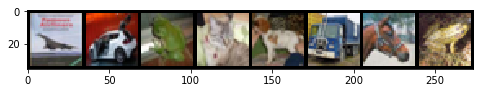

In [30]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Load a Saved Model 

In [33]:
# Instantiate the model and load saved parameters
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/CNN/CIFAR10-CNN-Model.pt'))
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
# Evaluate the saved model against the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 6123/10000 =  61.230%


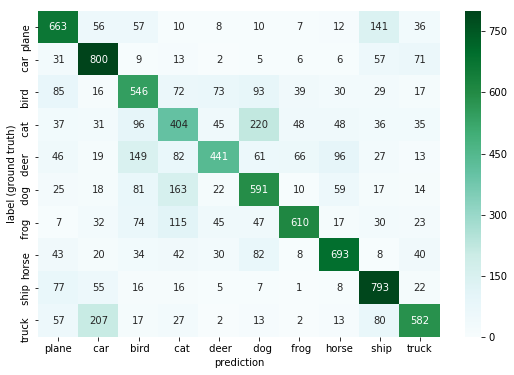

In [35]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();